**Setup & Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Settings
nz = 100       # Latent vector size
ngf = 64       # Generator feature maps
ndf = 64       # Discriminator feature maps
nc = 1         # Number of channels (grayscale)
image_size = 64
batch_size = 128
num_epochs = 50
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Pipeline**

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full dataset first
full_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

subset_size = 256  # Trying 128 for ultra-fast runs
subset_indices = list(range(subset_size))
dataset = torch.utils.data.Subset(full_dataset, subset_indices)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

**Generator & Discriminator Definitions**

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

**GAN Training Class**

In [ ]:
class GAN:
    def __init__(self, netG, netD, device, latent_dim=100, lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0):
        self.device = device
        self.netG = netG.to(device)
        self.netD = netD.to(device)
        self.latent_dim = latent_dim
        self.criterion = nn.BCELoss()
        self.optG = optim.Adam(netG.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optD = optim.Adam(netD.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.fixed_noise = torch.randn(64, latent_dim, device=device)
        self.history = {"G_losses": [], "D_losses": [], "images": []}

    def train(self, dataloader, num_epochs=50, log_interval=100):
        print("Starting Training Loop...")
        for epoch in range(1, num_epochs + 1):
            for i, (real_imgs, _) in enumerate(dataloader, 1):
                b_size = real_imgs.size(0)
                real_imgs = real_imgs.to(self.device)

                # --- Train Discriminator ---
                self.netD.zero_grad()
                label = torch.full((b_size,), 1.0, device=self.device)
                output = self.netD(real_imgs).view(-1)
                errD_real = self.criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item()

                noise = torch.randn(b_size, self.latent_dim, device=self.device)
                fake_imgs = self.netG(noise)
                label.fill_(0.0)
                output = self.netD(fake_imgs.detach()).view(-1)
                errD_fake = self.criterion(output, label)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                self.optD.step()

                # --- Train Generator ---
                self.netG.zero_grad()
                label.fill_(1.0)
                output = self.netD(fake_imgs).view(-1)
                errG = self.criterion(output, label)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optG.step()

                self.history["D_losses"].append(errD.item())
                self.history["G_losses"].append(errG.item())

                print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                      f"Loss_D: {errD:.4f} Loss_G: {errG:.4f} "
                      f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

            # Save sample grid
            with torch.no_grad():
                fake = self.netG(self.fixed_noise).cpu()
                grid = vutils.make_grid(fake, padding=2, normalize=True)
                self.history["images"].append(grid)

        print("Training Complete.")
        return self.history

**Baseline (No Regularization)**

In [ ]:
netG_base = Generator(nz, ngf, nc)
netD_base = Discriminator(nc, ndf)
gan_base = GAN(netG_base, netD_base, device)
history_base = gan_base.train(dataloader, num_epochs)

Starting Training Loop...
[1/50][1/2] Loss_D: 1.3626 Loss_G: 2.5600 D(x): 0.5456 D(G(z)): 0.5229/0.0799
[1/50][2/2] Loss_D: 1.1918 Loss_G: 3.2782 D(x): 0.9515 D(G(z)): 0.6673/0.0403
[2/50][1/2] Loss_D: 0.6087 Loss_G: 4.5085 D(x): 0.9345 D(G(z)): 0.4049/0.0118
[2/50][2/2] Loss_D: 0.3901 Loss_G: 4.8596 D(x): 0.8759 D(G(z)): 0.2055/0.0084
[3/50][1/2] Loss_D: 0.3126 Loss_G: 4.6643 D(x): 0.8502 D(G(z)): 0.1253/0.0101
[3/50][2/2] Loss_D: 0.2995 Loss_G: 6.1294 D(x): 0.9151 D(G(z)): 0.1770/0.0024
[4/50][1/2] Loss_D: 0.1262 Loss_G: 5.6360 D(x): 0.9267 D(G(z)): 0.0422/0.0040
[4/50][2/2] Loss_D: 0.1714 Loss_G: 6.5976 D(x): 0.9639 D(G(z)): 0.1240/0.0015
[5/50][1/2] Loss_D: 0.0814 Loss_G: 6.1618 D(x): 0.9557 D(G(z)): 0.0339/0.0023
[5/50][2/2] Loss_D: 0.0890 Loss_G: 6.4230 D(x): 0.9715 D(G(z)): 0.0567/0.0018
[6/50][1/2] Loss_D: 0.0825 Loss_G: 7.3255 D(x): 0.9787 D(G(z)): 0.0586/0.0007
[6/50][2/2] Loss_D: 0.0372 Loss_G: 6.8211 D(x): 0.9795 D(G(z)): 0.0156/0.0012
[7/50][1/2] Loss_D: 0.0566 Loss_G: 6.9

**L2 Regularization**

In [ ]:
netG_l2 = Generator(nz, ngf, nc)
netD_l2 = Discriminator(nc, ndf)
gan_l2 = GAN(netG_l2, netD_l2, device, weight_decay=0.01)
history_l2 = gan_l2.train(dataloader, num_epochs)

Starting Training Loop...
[1/50][1/2] Loss_D: 1.5215 Loss_G: 2.0803 D(x): 0.4920 D(G(z)): 0.5419/0.1301
[1/50][2/2] Loss_D: 1.3773 Loss_G: 2.8986 D(x): 0.9609 D(G(z)): 0.7273/0.0587
[2/50][1/2] Loss_D: 0.6561 Loss_G: 4.2228 D(x): 0.9253 D(G(z)): 0.4297/0.0154
[2/50][2/2] Loss_D: 0.4141 Loss_G: 4.1989 D(x): 0.8299 D(G(z)): 0.1777/0.0158
[3/50][1/2] Loss_D: 0.3591 Loss_G: 4.7902 D(x): 0.8890 D(G(z)): 0.1991/0.0089
[3/50][2/2] Loss_D: 0.3193 Loss_G: 5.5212 D(x): 0.8967 D(G(z)): 0.1770/0.0043
[4/50][1/2] Loss_D: 0.1853 Loss_G: 5.8843 D(x): 0.9281 D(G(z)): 0.0978/0.0030
[4/50][2/2] Loss_D: 0.1895 Loss_G: 6.1023 D(x): 0.9229 D(G(z)): 0.0965/0.0024
[5/50][1/2] Loss_D: 0.1348 Loss_G: 6.5549 D(x): 0.9529 D(G(z)): 0.0790/0.0016
[5/50][2/2] Loss_D: 0.0816 Loss_G: 6.4006 D(x): 0.9639 D(G(z)): 0.0424/0.0018
[6/50][1/2] Loss_D: 0.0857 Loss_G: 6.8692 D(x): 0.9727 D(G(z)): 0.0545/0.0011
[6/50][2/2] Loss_D: 0.0702 Loss_G: 6.8136 D(x): 0.9698 D(G(z)): 0.0379/0.0012
[7/50][1/2] Loss_D: 0.0586 Loss_G: 6.8

**Dropout in Discriminator**

In [ ]:
class DiscriminatorDropout(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_dropout = Generator(nz, ngf, nc)
netD_dropout = DiscriminatorDropout(nc, ndf)
gan_dropout = GAN(netG_dropout, netD_dropout, device)
history_dropout = gan_dropout.train(dataloader, num_epochs)

Starting Training Loop...
[1/50][1/2] Loss_D: 1.4733 Loss_G: 0.9320 D(x): 0.3925 D(G(z)): 0.3986/0.4021
[1/50][2/2] Loss_D: 1.3962 Loss_G: 1.8912 D(x): 0.9061 D(G(z)): 0.7152/0.1573
[2/50][1/2] Loss_D: 0.7856 Loss_G: 3.0796 D(x): 0.8228 D(G(z)): 0.4303/0.0504
[2/50][2/2] Loss_D: 0.6244 Loss_G: 3.0295 D(x): 0.7090 D(G(z)): 0.2201/0.0528
[3/50][1/2] Loss_D: 0.6275 Loss_G: 3.1855 D(x): 0.7626 D(G(z)): 0.2651/0.0457
[3/50][2/2] Loss_D: 0.6362 Loss_G: 4.3194 D(x): 0.8207 D(G(z)): 0.3204/0.0152
[4/50][1/2] Loss_D: 0.5415 Loss_G: 3.9328 D(x): 0.7567 D(G(z)): 0.1829/0.0222
[4/50][2/2] Loss_D: 0.6308 Loss_G: 4.9994 D(x): 0.7983 D(G(z)): 0.2882/0.0079
[5/50][1/2] Loss_D: 0.4710 Loss_G: 3.6623 D(x): 0.7574 D(G(z)): 0.1129/0.0300
[5/50][2/2] Loss_D: 0.5923 Loss_G: 6.0906 D(x): 0.8574 D(G(z)): 0.3186/0.0027
[6/50][1/2] Loss_D: 0.3561 Loss_G: 4.2899 D(x): 0.7794 D(G(z)): 0.0251/0.0157
[6/50][2/2] Loss_D: 0.3769 Loss_G: 5.8544 D(x): 0.9199 D(G(z)): 0.2302/0.0033
[7/50][1/2] Loss_D: 0.1676 Loss_G: 5.5

**BatchNorm Off (in Discriminator)**

In [ ]:
class DiscriminatorNoBN(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netG_bn = Generator(nz, ngf, nc)
netD_bn = DiscriminatorNoBN(nc, ndf)
gan_bn = GAN(netG_bn, netD_bn, device)
history_bn = gan_bn.train(dataloader, num_epochs)

Starting Training Loop...
[1/50][1/2] Loss_D: 1.3922 Loss_G: 0.7518 D(x): 0.5010 D(G(z)): 0.5040/0.4715
[1/50][2/2] Loss_D: 1.3241 Loss_G: 0.7965 D(x): 0.5251 D(G(z)): 0.4934/0.4509
[2/50][1/2] Loss_D: 1.2364 Loss_G: 0.9015 D(x): 0.5570 D(G(z)): 0.4784/0.4060
[2/50][2/2] Loss_D: 1.0970 Loss_G: 1.1031 D(x): 0.6110 D(G(z)): 0.4531/0.3318
[3/50][1/2] Loss_D: 0.9175 Loss_G: 1.4711 D(x): 0.6795 D(G(z)): 0.4109/0.2297
[3/50][2/2] Loss_D: 0.6383 Loss_G: 2.1089 D(x): 0.7755 D(G(z)): 0.3174/0.1214
[4/50][1/2] Loss_D: 0.3443 Loss_G: 3.4309 D(x): 0.8722 D(G(z)): 0.1856/0.0324
[4/50][2/2] Loss_D: 0.1144 Loss_G: 4.2970 D(x): 0.9449 D(G(z)): 0.0553/0.0136
[5/50][1/2] Loss_D: 0.0412 Loss_G: 5.7610 D(x): 0.9855 D(G(z)): 0.0260/0.0031
[5/50][2/2] Loss_D: 0.0163 Loss_G: 6.3615 D(x): 0.9917 D(G(z)): 0.0079/0.0017
[6/50][1/2] Loss_D: 0.0099 Loss_G: 6.4759 D(x): 0.9941 D(G(z)): 0.0039/0.0015
[6/50][2/2] Loss_D: 0.0073 Loss_G: 6.4382 D(x): 0.9959 D(G(z)): 0.0031/0.0016
[7/50][1/2] Loss_D: 0.0070 Loss_G: 6.3

**Evaluation – Loss Plots & Image Comparison**

Loss Plots

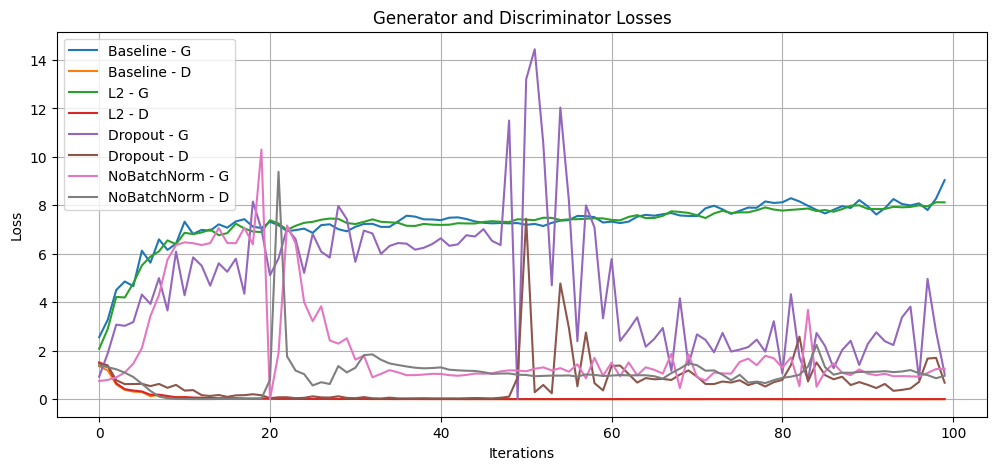

In [ ]:
def plot_losses(histories, labels):
    plt.figure(figsize=(12, 5))
    for h, label in zip(histories, labels):
        plt.plot(h['G_losses'], label=f'{label} - G')
        plt.plot(h['D_losses'], label=f'{label} - D')
    plt.title("Generator and Discriminator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)

Generated Image Comparison

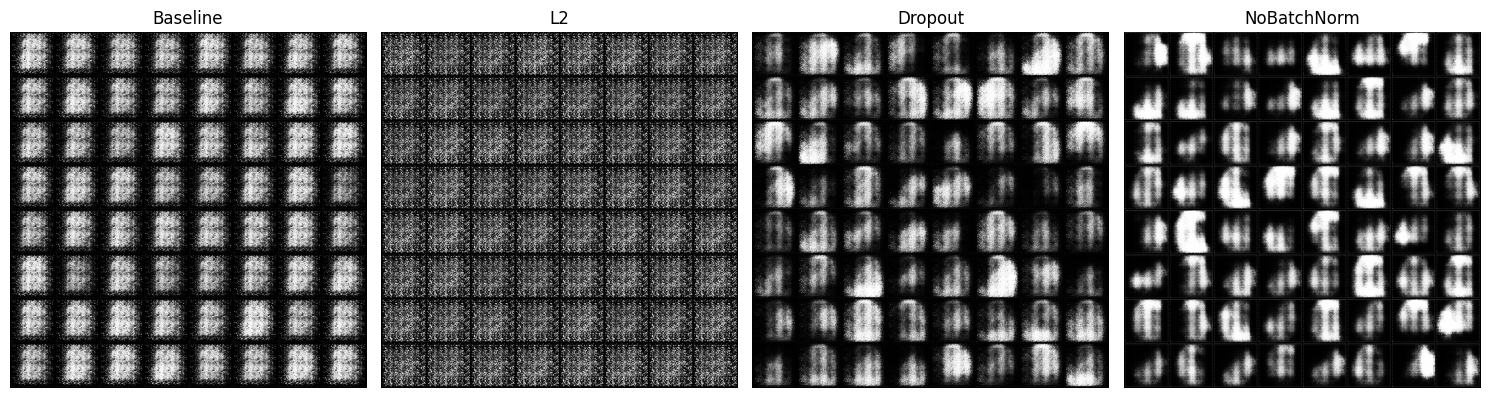

In [ ]:
def show_generated_images(histories, labels, epoch=-1):
    fig, axs = plt.subplots(1, len(histories), figsize=(15, 5))
    for i, (h, label) in enumerate(zip(histories, labels)):
        img = h["images"][epoch]
        axs[i].imshow(img.permute(1, 2, 0).numpy())
        axs[i].set_title(label)
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

show_generated_images(
    [history_base, history_l2, history_dropout, history_bn],
    ["Baseline", "L2", "Dropout", "NoBatchNorm"]
)